In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils as utils
import torch.optim as optim
import torch.distributions as D

import os

In [2]:
""" data generation
"""
 
def sample_data_1():
    count = 100000
    rand = np.random.RandomState(0)
    return [[1.0, 2.0]] + rand.randn(count, 2) * [[5.0, 1.0]]


def sample_data_2():
    count = 100000
    rand = np.random.RandomState(0)
    return [[1.0, 2.0]] + (rand.randn(count, 2) * [[5.0, 1.0]]).dot(
    [[np.sqrt(2) / 2, np.sqrt(2) / 2], [-np.sqrt(2) / 2, np.sqrt(2) / 2]])

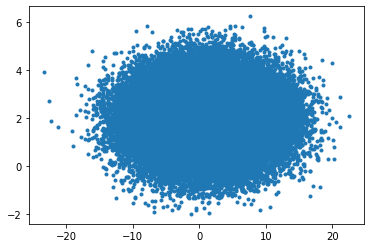

In [3]:
data1 = sample_data_1()
plt.scatter(data1[:, 0], data1[:, 1], marker='.')

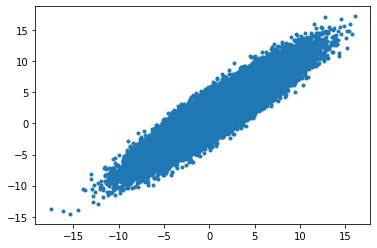

In [4]:
data2 = sample_data_2()
plt.scatter(data2[:, 0], data2[:, 1], marker='.')

# Full Covariance Gaussian

In [5]:
class NetConfig1(nn.Module):
    
    def __init__(self, n_layers=3, n_features=128):
        super(NetConfig1, self).__init__()
        self.n_features = n_features
        self.n_layers = n_layers
        self.layers = nn.ModuleList()
        
        self.layers.append(nn.Linear(2, self.n_features))
        for i in range(n_layers - 2):
            self.layers.append(nn.Linear(n_features, self.n_features))
        self.outlayer = nn.Linear(self.n_features, 4)
            
    def forward(self, x):
        for layer in self.layers:
            x = torch.relu(layer(x))
        z = self.outlayer(x)
        mu, log_var = torch.split(z, 2, dim=1)
        var = torch.exp(log_var)
        return mu, var

# Diagonal Gaussian

In [6]:
class NetConfig2(nn.Module):
    
    def __init__(self, n_layers=3, n_features=128):
        super(NetConfig2, self).__init__()
        self.n_features = n_features
        self.n_layers = n_layers
        self.layers = nn.ModuleList()
        
        self.layers.append(nn.Linear(2, self.n_features))
        for i in range(n_layers - 2):
            self.layers.append(nn.Linear(n_features, self.n_features))
        self.outlayer = nn.Linear(self.n_features, 3)
            
    def forward(self, x):
        for layer in self.layers:
            x = torch.relu(layer(x))
        z = self.outlayer(x)
        mu, log_var = torch.split(z, 2, dim=1)
        var = torch.exp(log_var * torch.ones([1, 2], dtype=torch.float32).cuda())
        return mu, var

In [7]:
""" Helper functions for training and visualization
"""
    
def log_prob(x, mu, var):
    return torch.sum(-0.5 * (torch.log(np.pi * 2 * var) + torch.pow(x - mu, 2) / var), dim=1, keepdim=True)


def train(encoder, decoder, data, n_epoch=10, lr=1e-3, batch_size=125):
    train_size = data.shape[0]
    n_iter_per_epoch = train_size // batch_size

    enc_optim = optim.Adam(encoder.parameters(), lr=lr)
    dec_optim = optim.Adam(decoder.parameters(), lr=lr)

    train_log_kl = []
    train_log_dec = []
    train_log_vlb = []

    for i in range(n_epoch):
        idx = np.random.permutation(train_size)
        for j in range(n_iter_per_epoch):
            batch = torch.from_numpy(data[idx[j * batch_size : (j + 1) * batch_size]]).float().cuda()

            mu_z, var_z = encoder(batch)

            epsilon = torch.randn(batch.shape).cuda()
            sampled_z = mu_z + epsilon * torch.sqrt(var_z)

            mu_x, var_x = decoder(sampled_z)

            nll = -torch.sum(log_prob(batch, mu_x, var_x), dim=1, keepdim=True)

            kl_div = 1.0 + torch.log(var_z) - torch.pow(mu_z, 2) - var_z
            kl_div = -0.5 * torch.sum(kl_div, dim=1, keepdim=True)

            loss = torch.mean(nll + kl_div)

            enc_optim.zero_grad()
            dec_optim.zero_grad()
            loss.backward()
            enc_optim.step()
            dec_optim.step()

            train_log_dec.append(torch.mean(nll).detach().item() / 2.0)
            train_log_kl.append(torch.mean(kl_div).detach().item())
            train_log_vlb.append(torch.mean(-loss).detach().item())
#         print("Epoch-{:d}/{:d} Iteration-{:d}/{:d} Loss-{:.5f}".format(i + 1, n_epoch, j + 1, n_iter_per_epoch, loss.item()))
    return train_log_vlb, train_log_kl, train_log_dec


def visualize_curves(train_log_vlb, train_log_kl, train_log_dec):
    gs = gridspec.GridSpec(2, 2)

    fig = plt.figure(figsize=(10, 10))

    ax = plt.subplot(gs[0])
    l = len(train_log_vlb)
    ax.plot(np.arange(l), train_log_vlb)
    ax.set_xlabel("Iterations")
    ax.set_title("VLB")

    ax = plt.subplot(gs[1])
    l = len(train_log_kl)
    ax.plot(np.arange(l), train_log_kl)
    ax.set_xlabel("Iterations")
    ax.set_title("KL-divergence")

    ax = plt.subplot(gs[2])
    l = len(train_log_dec)
    ax.plot(np.arange(l), train_log_dec)
    ax.set_xlabel("Iterations")
    ax.set_ylabel("bits/dim")
    ax.set_title("Decoder term")
    
    
def sample(decoder, n_samples=100000):
    z = torch.randn([n_samples, 2]).cuda()
    mu_x, var_x = decoder(z)
    noisy_x = torch.randn([n_samples, 2]).cuda() * torch.sqrt(var_x) + mu_x
    return noisy_x, mu_x


def visualize_samples(noisy_x, mu_x):
    noisy_x = noisy_x.cpu().data.numpy()
    mu_x = mu_x.cpu().data.numpy()
    plt.scatter(noisy_x[:, 0], noisy_x[:, 1], marker='.', label="Full path samples")
    plt.scatter(mu_x[:, 0], mu_x[:, 1], marker='.', label="Mean")
    plt.legend()

# VAE on image

In [ ]:
def sample_data_3():
    count = 100000
    rand = np.random.RandomState(0)
    a = [[-1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    b = [[1.5, 2.5]] + rand.randn(count // 3 + 1, 2) * 0.2 # Add one sample
    c = np.c_[2 * np.cos(np.linspace(0, np.pi, count // 3)),
    -np.sin(np.linspace(0, np.pi, count // 3))]
    c += rand.randn(*c.shape) * 0.2
    data_x = np.concatenate([a, b, c], axis=0)
    data_y = np.array([0] * len(a) + [1] * len(b) + [2] * len(c))
    perm = rand.permutation(len(data_x))
    return data_x[perm], data_y[perm]

In [ ]:
x, y = sample_data_3()
n_samples = x.shape[0]
idx = np.random.permutation(n_samples)
train_size = int(n_samples * 0.8)
x_train = x[idx[:train_size]]
y_train = y[idx[:train_size]]

x_test = x[idx[train_size:]]
y_test = x[idx[train_size:]]
test_size = x_test.shape[0]

plt.scatter(x_train[y_train == 0, 0], x_train[y_train == 0, 1], marker='.', label='Label 0')
plt.scatter(x_train[y_train == 1, 0], x_train[y_train == 1, 1], marker='.', label='Label 1')
plt.scatter(x_train[y_train == 2, 0], x_train[y_train == 2, 1], marker='.', label='Label 2')

In [ ]:
class Net(nn.Module):
    
    def __init__(self, n_layers=5, n_features=512):
        super(Net, self).__init__()
        self.n_features = n_features
        self.n_layers = n_layers
        self.layers = nn.ModuleList()
        
        self.inlayer = nn.Linear(2, self.n_features)
        for i in range(n_layers - 2):
            self.layers.append(nn.Linear(n_features, self.n_features))
        self.outlayer = nn.Linear(self.n_features, 4)
            
    def forward(self, x):
        x = torch.relu(self.inlayer(x))
        for layer in self.layers:
            x = torch.relu(layer(x)) + x 
        z = self.outlayer(x)
        mu, log_var = torch.split(z, 2, dim=1)
        var = torch.exp(log_var)
        return mu, var